In [32]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display

In [33]:
# Ruta donde tienes la base de datos UrbanSound8K
dataset_path = "/content/drive/MyDrive/UrbanSound8K/UrbanSound8K"
metadata_path = os.path.join(dataset_path, "metadata/UrbanSound8K.csv")

# Cargar el archivo CSV con las etiquetas
metadata = pd.read_csv(metadata_path)

# Parámetros de los espectrogramas Mel
n_mels = 128
n_fft = 2048
hop_length = 512
sr = 22050  # Frecuencia de muestreo estándar
fixed_length = 173  # Longitud fija en la dimensión del tiempo

# Listas para almacenar espectrogramas y etiquetas
X = []
y = []

# Contador para limitar a 10 archivos por clase
class_counts = {}

# Función para convertir audio en espectrograma Mel con padding o truncado
def extract_features(file_path, sr=22050):
    y, sr = librosa.load(file_path, sr=sr)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # Ajustar la longitud del espectrograma
    if mel_spec.shape[1] < fixed_length:
        pad_width = fixed_length - mel_spec.shape[1]
        mel_spec = np.pad(mel_spec, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_spec = mel_spec[:, :fixed_length]

    return mel_spec

In [34]:
# Procesar cada audio en UrbanSound8K
for index, row in metadata.iterrows():
    class_id = row["classID"]

    # Verificar si ya se alcanzaron 10 archivos para esta clase
    if class_counts.get(class_id, 0) >= 300:
        continue

    file_path = os.path.join(dataset_path, "audio", f"fold{row['fold']}", row['slice_file_name'])
    if os.path.exists(file_path):
        features = extract_features(file_path, sr)
        X.append(features)
        y.append(class_id)
        class_counts[class_id] = class_counts.get(class_id, 0) + 1

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(


In [35]:
# Convertir a arrays de NumPy
X = np.array(X)
y = np.array(y)

In [36]:
# Verificar dimensiones
print(f"Shape de X: {X.shape}")  # (n_samples, n_mels, fixed_length)
print(f"Shape de y: {y.shape}")  # (n_samples,)

Shape de X: (3000, 128, 173)
Shape de y: (3000,)


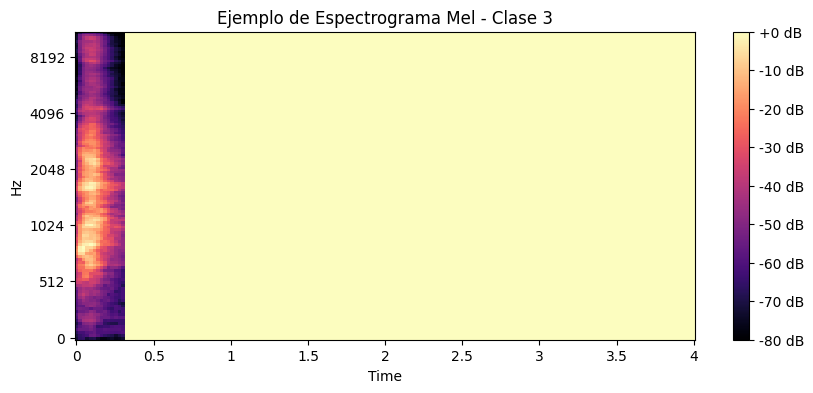

In [37]:
# Visualizar un ejemplo de espectrograma Mel
if len(X) > 0:
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(X[0], sr=sr, hop_length=hop_length, x_axis="time", y_axis="mel")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Ejemplo de Espectrograma Mel - Clase {y[0]}")
    plt.show()

In [38]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [39]:
# Ajustar dimensiones de entrada para la CNN
X = np.expand_dims(X, axis=-1)  # Añadir canal de profundidad (grayscale)

# Dividir datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Construcción de la CNN
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(X.shape[1], X.shape[2], 1)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),  # Reduce sobreajuste
    layers.Dense(10, activation='softmax')  # 10 clases de UrbanSound8k
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 126, 171, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 85, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 83, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 41, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 39, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 34048)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       4,358,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,452,234 (16.98 MB)

 Trainable params: 4,452,234 (16.98 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
# Entrenar la CNN
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.2074 - loss: 6.5875 - val_accuracy: 0.4433 - val_loss: 1.5596
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.4741 - loss: 1.5359 - val_accuracy: 0.4667 - val_loss: 1.4684
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.5302 - loss: 1.3065 - val_accuracy: 0.6417 - val_loss: 1.0860
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.6542 - loss: 1.0638 - val_accuracy: 0.7600 - val_loss: 0.7224
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7012 - loss: 0.8760 - val_accuracy: 0.7783 - val_loss: 0.6605
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.7995 - loss: 0.5940 - val_accuracy: 0.7950 - val_loss: 0.6080
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.8242 - loss: 0.5374 - val_accuracy: 0.8250 - val_loss: 0.5403
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.8275 - loss: 0.5086 - val_accuracy: 0.7883 - v

In [42]:
# Evaluar el modelo
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Precisión en datos de prueba: {test_acc:.2f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 336ms/step - accuracy: 0.8981 - loss: 0.3375
Precisión en datos de prueba: 0.88


In [45]:
model.save('/content/mi_modelo.h5')

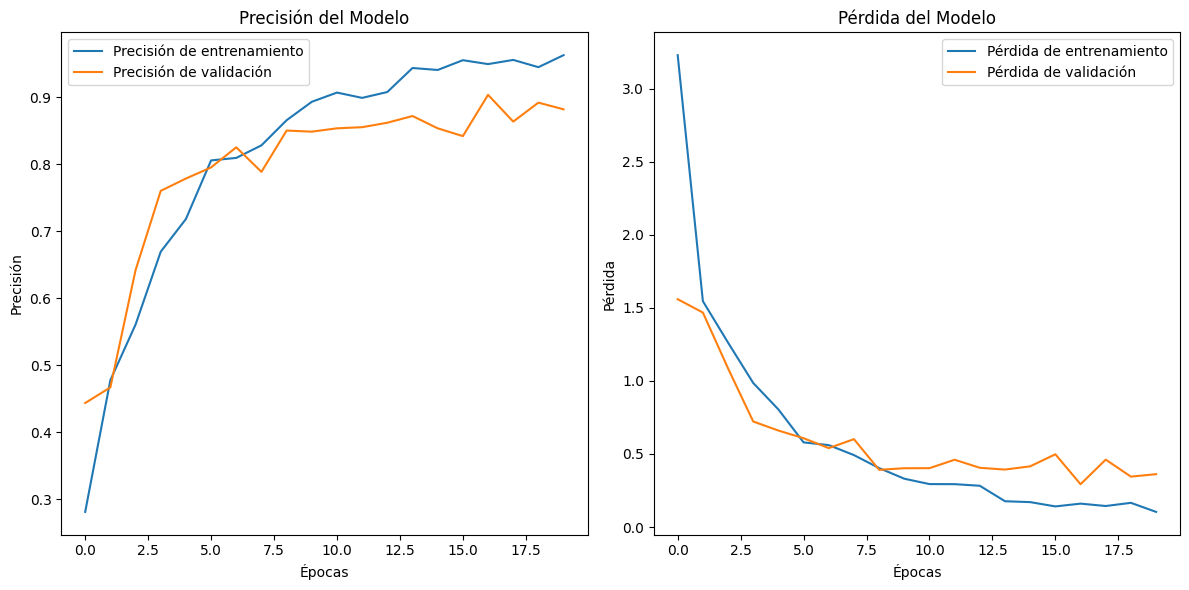

In [43]:
import matplotlib.pyplot as plt

# Graficar la precisión de entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()


In [47]:
import librosa
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import os

# Función para cargar el modelo preentrenado
def load_model():
    # Asegúrate de haber entrenado y guardado tu modelo previamente
    model = tf.keras.models.load_model("/content/mi_modelo.h5")
    return model

# Función para extraer el espectrograma Mel de un archivo de audio
def extract_features(file_path, sr=22050, n_mels=128, n_fft=2048, hop_length=512):
    y, _ = librosa.load(file_path, sr=sr)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  # Convertir a dB
    return mel_spec

# Segmentación del audio en bloques pequeños
def segment_audio(file_path, segment_duration=3, sr=22050):
    y, _ = librosa.load(file_path, sr=sr)
    segment_samples = int(segment_duration * sr)

    # Dividir el audio en segmentos de duración `segment_duration`
    segments = [y[i:i+segment_samples] for i in range(0, len(y), segment_samples)]

    # Si el último segmento es muy corto, lo descartamos
    if len(segments[-1]) < segment_samples:
        segments = segments[:-1]

    return segments

# Predicción sobre un segmento de audio
def predict_segment(segment, model, sr=22050):
    # Extraer características Mel
    mel_spec = extract_features(segment, sr=sr)
    mel_spec = np.expand_dims(mel_spec, axis=-1)  # Añadir dimensión de canal para la CNN
    mel_spec = np.expand_dims(mel_spec, axis=0)  # Añadir dimensión de batch

    # Predicción con el modelo
    prediction = model.predict(mel_spec)
    predicted_class = np.argmax(prediction)
    return predicted_class

# Función para procesar el audio completo
def predict_audio(file_path, model, segment_duration=3):
    # Segmentamos el audio
    segments = segment_audio(file_path, segment_duration)

    # Realizamos la predicción para cada segmento
    predictions = [predict_segment(segment, model) for segment in segments]

    # Reunificación: Votación mayoritaria
    final_prediction = np.bincount(predictions).argmax()

    return final_prediction

# Función principal de predicción
def main(audio_file):
    # Cargar el modelo
    model = load_model()

    # Predecir la clase del audio
    prediction = predict_audio(audio_file, model)

    # Mapear la predicción al nombre de la clase
    class_labels = ["air_conditioner", "car_horn", "children_playing", "dog_bark",
                    "drilling", "engine_idling", "gun_shot", "jackhammer",
                    "siren", "street_music"]

    predicted_class = class_labels[prediction]
    print(f"La clase predicha para el audio es: {predicted_class}")


In [50]:
import librosa
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import os

# Función para cargar el modelo preentrenado
def load_model():
    # Asegúrate de haber entrenado y guardado tu modelo previamente
    model = tf.keras.models.load_model("/content/mi_modelo.h5")
    return model

# Función para extraer el espectrograma Mel de un archivo de audio
def extract_features(y, sr=22050, n_mels=128, n_fft=2048, hop_length=512):
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  # Convertir a dB
    return mel_spec

# Segmentación del audio en bloques pequeños
def segment_audio(file_path, segment_duration=3, sr=22050):
    y, _ = librosa.load(file_path, sr=sr)
    segment_samples = int(segment_duration * sr)

    # Dividir el audio en segmentos de duración `segment_duration`
    segments = [y[i:i+segment_samples] for i in range(0, len(y), segment_samples)]

    # Si el último segmento es muy corto, lo descartamos
    if len(segments[-1]) < segment_samples:
        segments = segments[:-1]

    return segments

# Predicción sobre un segmento de audio
def predict_segment(segment, model, sr=22050):
    # Extraer características Mel
    mel_spec = extract_features(segment, sr=sr)
    mel_spec = np.expand_dims(mel_spec, axis=-1)  # Añadir dimensión de canal para la CNN
    mel_spec = np.expand_dims(mel_spec, axis=0)  # Añadir dimensión de batch

    # Predicción con el modelo
    prediction = model.predict(mel_spec)
    predicted_class = np.argmax(prediction)
    return predicted_class

# Función para procesar el audio completo
def predict_audio(file_path, model, segment_duration=3):
    # Segmentamos el audio
    segments = segment_audio(file_path, segment_duration)

    # Realizamos la predicción para cada segmento
    predictions = [predict_segment(segment, model) for segment in segments]

    # Reunificación: Votación mayoritaria
    final_prediction = np.bincount(predictions).argmax()

    return final_prediction

# Función principal de predicción
def main(audio_file):
    # Cargar el modelo
    model = load_model()

    # Predecir la clase del audio
    prediction = predict_audio(audio_file, model)

    # Mapear la predicción al nombre de la clase
    class_labels = ["air_conditioner", "car_horn", "children_playing", "dog_bark",
                    "drilling", "engine_idling", "gun_shot", "jackhammer",
                    "siren", "street_music"]

    predicted_class = class_labels[prediction]
    print(f"La clase predicha para el audio es: {predicted_class}")


In [51]:
# Llamada a la función principal con el archivo de audio
audio_file = "/content/ladridos.wav"
main(audio_file)

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 34048, but received input with shape (1, 25088)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 128, 130, 1), dtype=float32)
  • training=False
  • mask=None